In [1]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

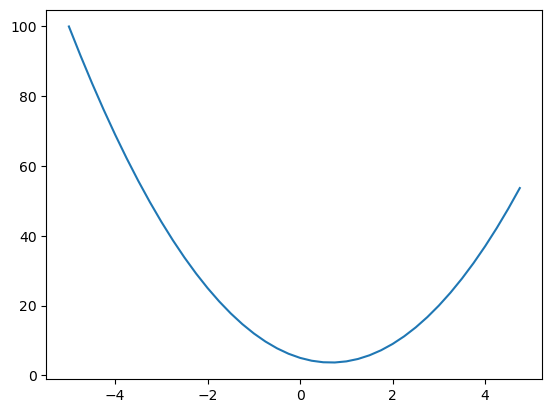

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.00001
x = 2/3
(f(x+h) - f(x))/h

3.0000002482211127e-05

In [6]:
a=2.0
b=-3.0
c=10.0
d = a*b+c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c=10.0

d1 = a*b+c
c +=h
d2 = a*b + c

print('d1 =', d1)
print('d2 =', d2)
print('slope =',  (d2 - d1)/h )

d1 = 4.0
d2 = 4.0001
slope = 0.9999999999976694


In [161]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data*other.data,(self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
            
        out._backward = _backward
        
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supprting int/float powers"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data ** (other-1)) * out.grad
        
        out._backward = _backward
        return out
    
    def __rmul__(self, other): # other * self
        return self * other
    
    def __truediv__(self, other): # self/other
        return self * other **-1
    
    def __neg__(self): # - self
        return self *-1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __radd__(self,other): # other + self
        return self + other
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) -1)/ (math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1-t**2) * out.grad
            
        out._backward = _backward
        return out 
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def backward(self):
        
        # toplogically sort the graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        
        build_topo(self)
        self.grad = 1.0

        for node in reversed(topo):
            node._backward()   

In [159]:
a = Value(2.0)
b = Value(4.)

a/b

Value(data=0.5)

In [ ]:



a  = Value(data=2.0, label='a')
b = Value(data=-3.0, label='b')
c = Value(data=10.0, label='c')
e = a*b; e.label ='e'
d = e+c;d.label ='d'
f = Value(-2.0,label='f')
L = d*f;L.label  = 'L' # ouput of the graph
L
#d= a * b + c
#(a.__mul__((b))).__add__(c)

In [3]:
%pip --cert "$HOME/.mac-ca-roots" install graphviz 

  Using cached graphviz-0.20.1-py3-none-any.whl (47 kB)

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: /opt/anaconda3/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [16]:
from graphviz import Digraph

def trace(root):
    "Builds a set of all nodes and edges in a graph"
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph creatre a rectangular record node for it
        dot.node(name=uid, label = "{ %s| data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            # if this value is a result of an operation, create op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and then connect the node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op of node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

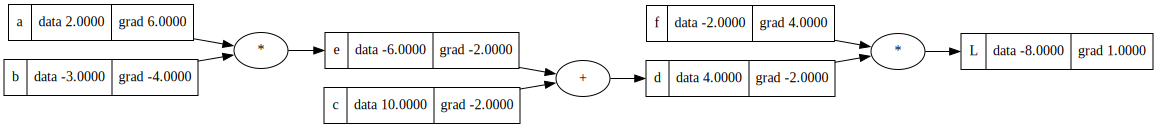

In [31]:
draw_dot(L)

In [30]:
# dervie dL/ dc and dL/de
# what is dd/ dc ? 1.0
# by symmetry dd/de =1.0 also

d = c + e

# WANT: dL / dc = (dL*dd) * (dd/dc)
# KNOW: dL/ dd = -2
# KNOW: dd/dc = 1.0

# Pluses merely route the gradients b/c 1.0


In [48]:
# L = d * f
# What is dL/dd ? = f
# proof:  (f(x+h)-f(x))/h -> ((d*h)*f - d*f/h -> (h*f)/h -> f
L.grad = 1.0
f.grad = 4.0
d.grad = -2 #f.data

In [49]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

In [50]:
e = a*b
d = e+c
L = d*f

print(L.data)

-7.84


In [33]:
def lol():    
    h =0.0001
    a  = Value(data=2.0, label='a')
    b = Value(data=-3.0, label='b')
    c = Value(data=10.0, label='c')
    e = a*b; e.label ='e'
    d = e+c;d.label ='d'
    f = Value(-2.0,label='f')
    L = d*f;L.label  = 'L' # ouput of the graph
    L1 = L.data
    
    
    a  = Value(data=2.0, label='a')
    b = Value(data=-3.0, label='b')
    c = Value(data=10.0, label='c')
    e = a*b; e.label ='e'
    d = e+c;d.label ='d'
    f = Value(-2.0,label='f')
    L = d*f;L.label  = 'L' # ouput of the graph
    L2 = L.data 
    
    print((L2-L1)/h)

lol()

-4.000000000008441


# Backpropagate Through a Neuron

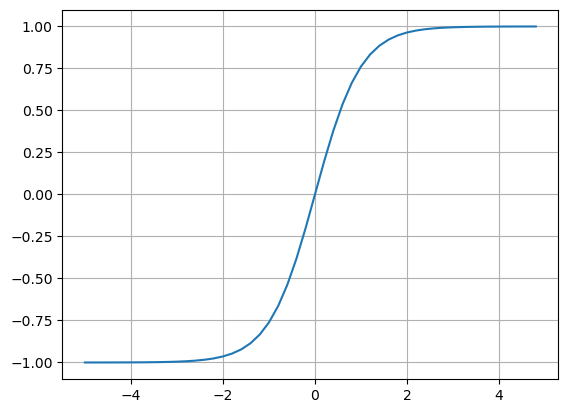

In [38]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

In [162]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

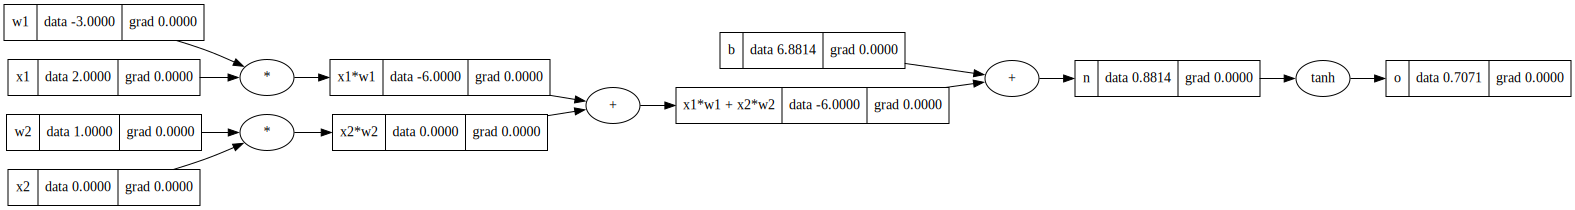

In [163]:
draw_dot(o)

In [135]:
o.backward()

In [116]:
# toplogically sort the graph
topo = []
visited = set()
def build_topo(v):
    if v not in visited:
        visited.add(v)
        for child in v._prev:
            build_topo(child)
        topo.append(v)
build_topo(o)
topo

[Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=6.881373587019543),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [106]:
o.grad = 1.0
o._backward()

In [109]:
n._backward()

In [110]:
b._backward()

In [112]:
x1w1x2w2._backward()

In [114]:
x2w2._backward()
x1w1._backward()

In [78]:
# o = tanh(n)
# do/dn = 1 - tanh(n)**2 = 1-o**2
n.grad = 0.5 #1 - o.data**2

In [79]:
# b/c 1 * 5
x1w1x2w2.grad=5.0
b.grad=5.0

In [80]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [81]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

# 2nd Part

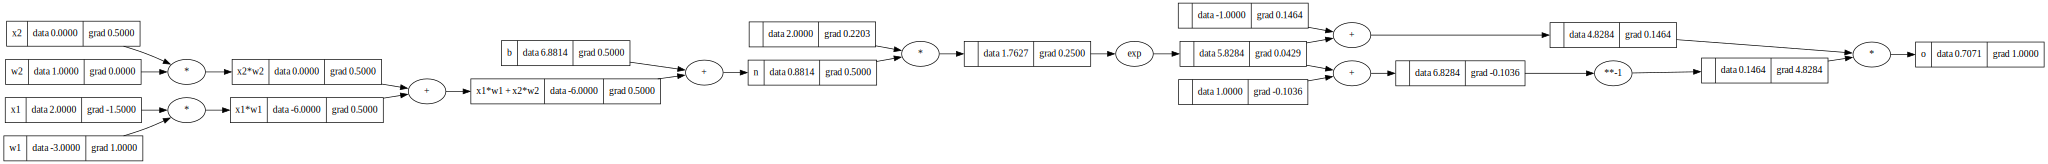

In [164]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e-1) / (e+1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

In [165]:
import torch

In [166]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [53]:
import math
import random
from value import Value

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        act = sum((wi * xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

    def parameters(self):
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i + 1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


n= MLP(3, [4,4,1])

In [54]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [55]:
ypred = [n(x) for x in xs]
loss = sum((yout-ygt)**2 for ygt, yout in zip(ys,ypred))
loss

Value(data=5.7050848122718225)

In [56]:
loss.backward()

In [57]:
from drawdot import draw_dot

#draw_dot(loss)

In [58]:
n.parameters()[0:3]

[Value(data=-0.12214135358598566),
 Value(data=0.4803523768967375),
 Value(data=-0.21521819583733426)]

In [59]:
for p in n.parameters():
    p.data += -0.01 * p.grad    

In [60]:
n.parameters()[0:3]

[Value(data=-0.1189197895501604),
 Value(data=0.4795858470483271),
 Value(data=-0.2166953069417684)]

In [61]:
for k in range(20):
    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt,yout in zip(ys,ypred))
    
    #backward pass
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    # update
    for p in n.parameters():
        p.data += -0.1 * p.grad
    
    print(k, loss.data)

0 5.296480923840473
1 3.8053599864219607
2 3.721241544298529
3 3.9795222307723597
4 1.6804376963109744
5 0.8147122472344132
6 0.271134523624485
7 0.051584920115940576
8 0.040632682185705385
9 0.03416364565619095
10 0.02979940155865867
11 0.026611062479693564
12 0.02415364163919787
13 0.022185253618478437
14 0.020562358569973526
15 0.01919403120710388
16 0.01801966796283954
17 0.016997184092859767
18 0.016096347789238085
19 0.015294813953396267


Value(data=0.006894835291560128)